# Example 5. NFL 2009 network

The vertices of the network represent 32 professional American football teams in the National Football League (NFL). If two teams played together in the season of 2009, they are connected with an edge. All teams arranged in two equal conferences, each of them is split into 4 divisions. The games are scheduled according to the divisions, hence, not all teams play with each other.

In this experiment we attend to replicate the results of the previous work[1], which demonstrates how the DCSBM can divide the vertices into four groups, so each one is connected within itself and with only two other groups.

[1] C. Aicher, A.Z. Jacobs and A. Clauset, "Learning latent block structure in weighted networks." Journal of Complex Networks 3(2), 221–248 (2015).

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import sys
sys.path.append('../src/')
from vi_sbm import *
from graph_models import EdgesDataset
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from utils import permute_classes

torch.manual_seed(17)

We start with the data import and aggregate the links into adjacency matrix $A$.

The true group assignment `z_true` with four groups is known.

In [2]:
edges = pd.read_csv('../data/NFL2009_network/NFL2009_EdgeList.txt', sep='\t')
vertices = pd.read_csv('../data/NFL2009_network/NFL2009_VertexMetadata.txt', sep='\t')

N = 32
num_classes = 4
A = torch.zeros((N,N))
for e in np.array(edges):
    A[e[0]-1,e[1]-1] = 1
    A[e[1]-1,e[0]-1] = 1

classes_4 = np.array([1,1,0,3,1,2,0,0,2,0,2,2,3,3,3,0,3,2,3,1,2,3,0,2,0,0,1,1,1,1,3,2])
z_true = torch.tensor(OneHotEncoder(sparse=False).fit_transform(classes_4.reshape(-1, 1))) 

 /home/mo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning:The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly. 


Here is the network's adjacency matrix $A$.

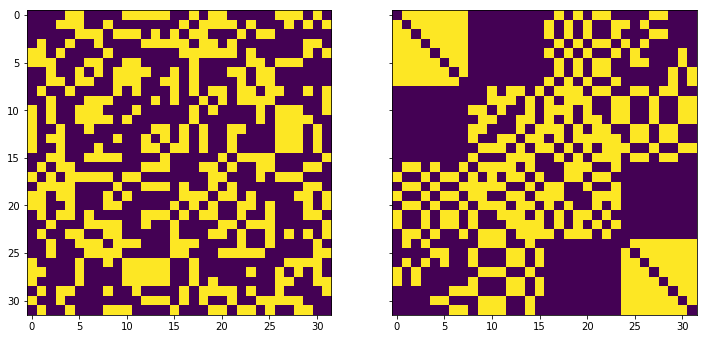

In [3]:
order = z_true.argmax(dim=1).argsort()
A_ordered = A[order,:][:,order]
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].imshow(A) 
axs[1].imshow(A_ordered) 
plt.show()

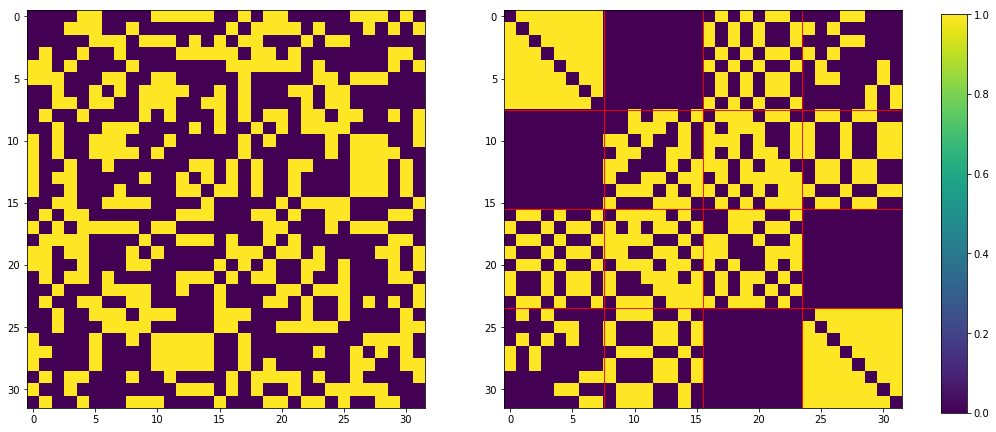

In [4]:
class_sizes = lambda classes: np.array(pd.Series(classes.numpy()).value_counts().sort_index())
cs = class_sizes(z_true.argmax(dim=1))
order = z_true.argmax(dim=1).argsort()
fig, axs = plt.subplots(1,2, figsize=(18,9))

axs[0].imshow(A.numpy(), cmap='viridis')
ax = axs[1].imshow(A[order,:][:,order].numpy(), cmap='viridis')
acc = -0.5
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/ex5_A.pdf')
plt.show()

## SBM

First, we try the standard SBM. The default prior distribution in `VIRGMo` is quite flat but for this example we may use a more sharp one. We assume that the sizes of both groups are similar, and the nodes are connected densely within the groups as outside.

In [5]:
def generate_B_prior(inside, outside, num_classes):
    prior = torch.ones([num_classes, num_classes, 2])*torch.tensor(outside)
    for i in range(num_classes):
        prior[i,i] = torch.tensor(inside)
    return prior

In [6]:
sns.set()

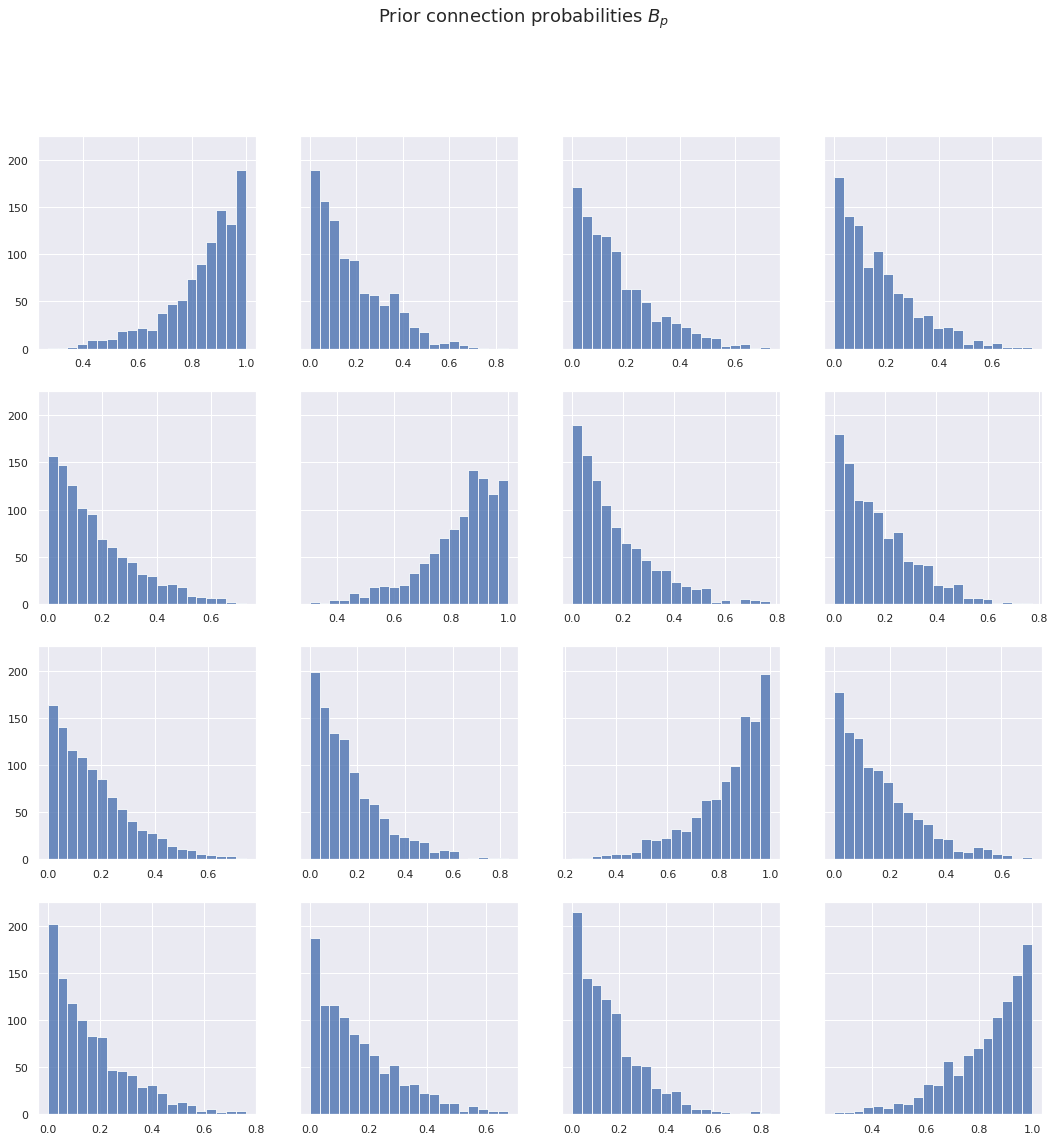

In [7]:
B_p = generate_B_prior(inside=[5., 1],outside=[1, 5.],num_classes=num_classes)

num_samples = 1000
B_samples = Beta(B_p[:,:,0], B_p[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Prior connection probabilities $B_p$', fontsize=18)
plt.show()

In [8]:
theta_p = torch.ones([num_classes])*15
dataloader = DataLoader(EdgesDataset(A), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_SBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':B_p},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None})
trials = 100
vi.multi_train(dataloader, epochs=20, lrs = [0.5, 0.1, 0.01], trials=trials)

>>>>>>> Start multi-training...
>>> Trial 1/100 | Final loss: 733.71 | Trial time 4.96
>>> Trial 2/100 | Final loss: 732.80 | Trial time 5.09
>>> Trial 3/100 | Final loss: 740.13 | Trial time 7.19
>>> Trial 4/100 | Final loss: 705.90 | Trial time 8.34
>>> Trial 5/100 | Final loss: 731.55 | Trial time 5.77
>>> Trial 6/100 | Final loss: 733.90 | Trial time 5.25
>>> Trial 7/100 | Final loss: 733.76 | Trial time 5.39
>>> Trial 8/100 | Final loss: 667.86 | Trial time 7.32
>>> Trial 9/100 | Final loss: 732.62 | Trial time 8.44
>>> Trial 10/100 | Final loss: 733.74 | Trial time 7.85
>>> Trial 11/100 | Final loss: 733.54 | Trial time 5.04
>>> Trial 12/100 | Final loss: 733.74 | Trial time 5.01
>>> Trial 13/100 | Final loss: 735.15 | Trial time 4.94
>>> Trial 14/100 | Final loss: 664.98 | Trial time 4.93
>>> Trial 15/100 | Final loss: 731.86 | Trial time 4.96
>>> Trial 16/100 | Final loss: 734.00 | Trial time 4.93
>>> Trial 17/100 | Final loss: 735.48 | Trial time 4.95
>>> Trial 18/100 | Final 

Further, we analyze the trial with the smallest loss.

In [9]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [10]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B = vi.constrained_params()

In [11]:
print('Estimated class probabilities:', vi.multi_results[1][best_trial].numpy())
print('True class probabilities:     ', z_true.sum(dim=0).float().numpy()/32)

Estimated class probabilities: [0.24 0.25 0.25 0.26]
True class probabilities:      [0.25 0.25 0.25 0.25]


Let us plot the network arranging nodes into clusters according to the estimated class assignments.

In [12]:
def plot_clusters(A, num_clusters, labels, colors, save_path=None):
    ''' Plot the network from the adjacency matrix A and arrange 
    the nodes into clusters according to the class assignment.
    '''
    G = nx.Graph(A)
    pos = nx.circular_layout(G)
    angs = np.linspace(0, 2*np.pi, num_clusters+1)
    repos = []
    rad = 3.5     # radius of circle
    for ea in angs:
        if ea > 0:
            repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
    for ea in pos.keys():
        #color = 'black'
        posx = labels[ea]
        pos[ea] += repos[posx]
    plt.figure(figsize=(8,8))
    nx.draw_networkx(G, pos=pos, node_color=colors)
    if not save_path is None:
        plt.savefig(save_path)
    plt.show()

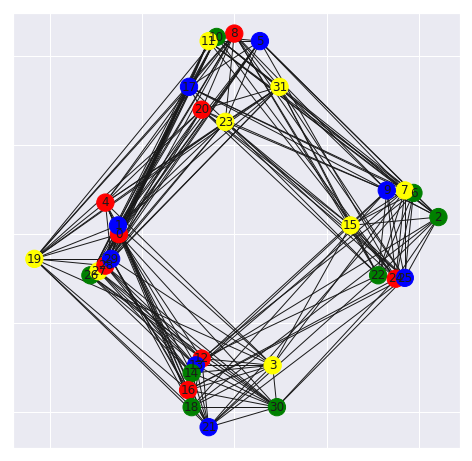

In [13]:
labels = q_eta.argmax(dim=0).clone()
colors = ['red', 'blue', 'green', 'yellow']
labels_perm = permute_classes(labels.float(), [0,2,1,3])  # Permute for better look
plot_clusters(A.numpy(), num_classes, labels_perm.int().numpy(), colors) #, '../examples/images/ex5_net_sbm.pdf')

But what happend with other trials?

In [14]:
success = 0
for i in range(len(vi.multi_results[0])):
    if vi.class_accuracy(z_true,vi.multi_results[0][i]).item()==1:
        success += 1
print('The number of successfull trials is %d from %d' % (success, trials))

The number of successfull trials is 1 from 100


As you can see, the standard SBM have managed to find the correct class assignment but the success rate is quite low. Note, that the model with the original assignment also has the smallest loss (highest ELBO).

## DCSBM

Next, we try the DCSBM with the same prior as for the SBM. As in the preivious examples we initialize $\delta$ with the observed degree distributions.

In [15]:
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [ ]:
dataloader = DataLoader(EdgesDataset(A), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_DCSBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':B_p,
                           'delta_p':None},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None,
                                'deltas':delta_init})
trials = 100
vi.multi_train(dataloader, epochs=20, lrs = [0.1, 0.05, 0.01], trials=trials)

>>>>>>> Start multi-training...
>>> Trial 1/100 | Final loss: 667.22 | Trial time 12.30
>>> Trial 2/100 | Final loss: 650.89 | Trial time 13.41
>>> Trial 3/100 | Final loss: 597.20 | Trial time 13.61
>>> Trial 4/100 | Final loss: 680.40 | Trial time 11.66
>>> Trial 5/100 | Final loss: 646.37 | Trial time 10.89
>>> Trial 6/100 | Final loss: 673.12 | Trial time 9.37
>>> Trial 7/100 | Final loss: 624.43 | Trial time 9.70
>>> Trial 8/100 | Final loss: 684.54 | Trial time 9.33
>>> Trial 9/100 | Final loss: 743.19 | Trial time 11.18
>>> Trial 10/100 | Final loss: 706.47 | Trial time 9.86
>>> Trial 11/100 | Final loss: 634.96 | Trial time 9.51
>>> Trial 12/100 | Final loss: 769.93 | Trial time 9.05
>>> Trial 13/100 | Final loss: 678.29 | Trial time 9.14
>>> Trial 14/100 | Final loss: 693.24 | Trial time 9.23
>>> Trial 15/100 | Final loss: 703.63 | Trial time 9.14
>>> Trial 16/100 | Final loss: 679.90 | Trial time 8.77
>>> Trial 17/100 | Final loss: 681.68 | Trial time 8.85
>>> Trial 18/100 | 

In [ ]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [ ]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta = vi.constrained_params()

In [ ]:
print('Estimated class probabilities:', vi.multi_results[1][best_trial].numpy())
print('True class probabilities:     ', z_true.sum(dim=0).float().numpy()/32)

In [ ]:
labels = q_eta.argmax(dim=0).clone()
colors = ['red', 'blue', 'green', 'yellow']
labels_perm = permute_classes(labels.float(), [1,0,2,3])  # Permute for better look
plot_clusters(A.numpy(), num_classes, labels_perm.int().numpy(), colors)

In [ ]:
success = 0
for i in range(len(vi.multi_results[0])):
    if vi.class_accuracy(z_true,vi.multi_results[0][i]).item()==1:
        success += 1
print('The number of successfull trials is %d from %d' % (success, trials))

The DCSBM also has found the correct class assignment and it was more successfull comparing the number of trials as the SBM. Further, we may inspect the estimated $\theta$ and $B$ distributions in the best trial.

In [ ]:
q_B_perm = q_B.detach() #[permutation,:,:][:,permutation,:]
num_samples = 1000
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
plt.show()